In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Using PyTorch Accelaration using Apple Silicon 'MPS' GPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

## New CNN using:
* Batch Normalisation
* L1 Normalisation
* L2 Normalisation

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # Batch normalization
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)  # Batch normalization
        self.fc = nn.Linear(7 * 7 * 32, 10)
        self.l1 = nn.L1Loss()  # L1 normalization
        self.l2 = nn.MSELoss()  # L2 normalization

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [4]:
# Load the Fashion MNIST dataset
train_dataset = FashionMNIST(root='./data', train=True, transform=ToTensor(), download=True)
test_dataset = FashionMNIST(root='./data', train=False, transform=ToTensor())


In [5]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [6]:
# Create an instance of the CNN and move it to the GPU
model = CNN().to(device)

In [7]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Training loop
for epoch in range(10):  # Number of epochs
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{10}', unit='batch', leave=False):
        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print('Epoch: %d, Loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

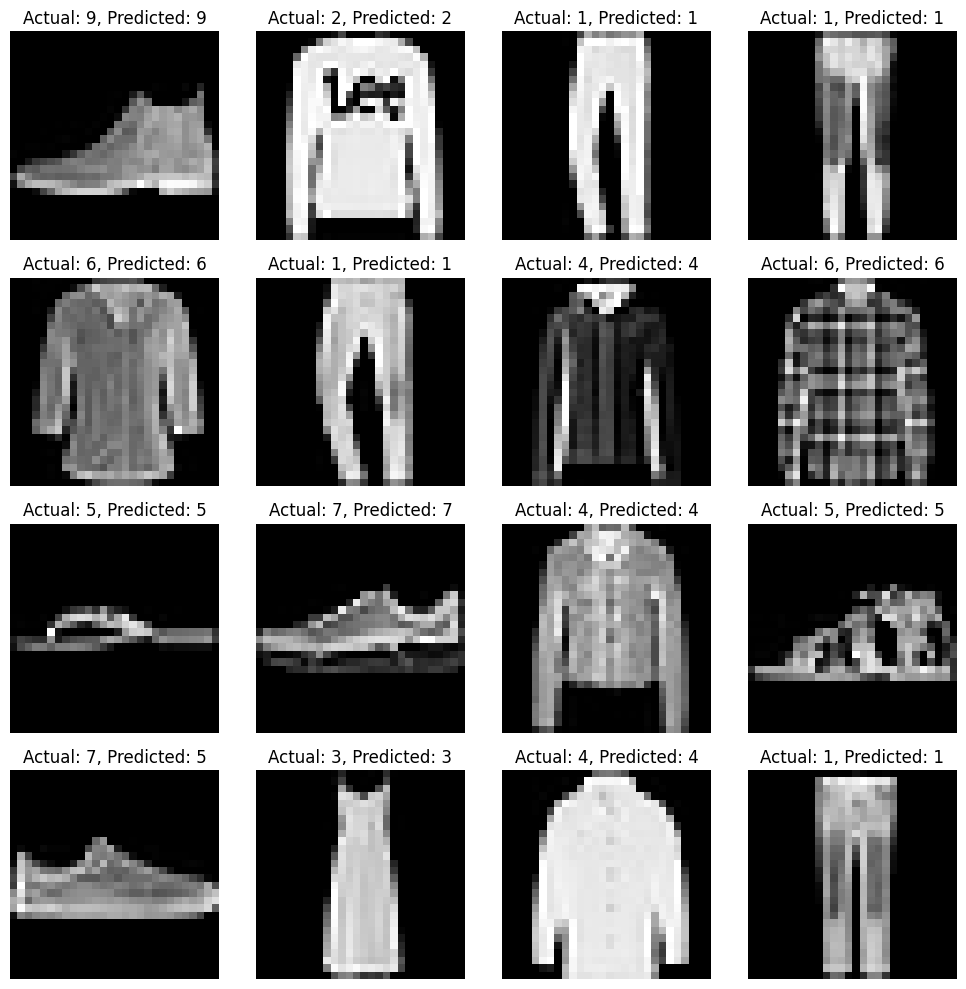

In [9]:
with torch.no_grad():
    count = 0
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()
    
    for images, labels in test_loader:
        # Move data to GPU
        images = images.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Move data to CPU
        images = images.cpu()
        labels = labels.cpu()
        predicted = predicted.cpu()

        # Convert tensor to numpy array
        images_np = images.numpy()
        labels_np = labels.numpy()
        predicted_np = predicted.numpy()

        # Plot sample images
        for i in range(images_np.shape[0]):
            axes[count].imshow(images_np[i][0], cmap='gray')
            axes[count].set_title(f'Actual: {labels_np[i]}, Predicted: {predicted_np[i]}')
            axes[count].axis('off')

            count += 1
            if count == 16:
                break
        
        if count == 16:
            break

    plt.tight_layout()
    plt.show()


In [10]:
# Evaluate the model on the test set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test set: %.2f %%' % (100 * correct / total))

Accuracy on the test set: 90.04 %
